Imports And Init

In [1]:
from datetime import datetime
import numpy as np
from scipy.fft import fft, fftfreq
from scipy.signal import butter, filtfilt
import json
import mysql.connector
import ast

db_config = {
    'host': '150.140.186.118',
    'port': 3306,
    'user': 'readonly_student',
    'password': 'iot_password',
    'database': 'default'
}


Fetch Data

In [2]:
def fetch_data(table_name, attr_name, start_datetime=None, end_datetime=None):
    
    try:
        # Establish the connection to the database
        connection = mysql.connector.connect(**db_config)
        cursor = connection.cursor()

        query = f"""
            SELECT 
                R1.attrValue AS timestamp,
                R2.attrValue AS location, 
                R4.attrValue AS acc_x, 
                R5.attrValue AS acc_y, 
                R6.attrValue AS acc_z,
                R7.attrValue AS speed,
                R8.attrValue AS altitude
            FROM 
                `default`.AutoSenseAnalytics_IMU_Measurement_raw AS R1 
            JOIN 
                `default`.AutoSenseAnalytics_IMU_Measurement_raw AS R2 
            JOIN 
                `default`.AutoSenseAnalytics_IMU_Measurement_raw AS R4 
            JOIN 
                `default`.AutoSenseAnalytics_IMU_Measurement_raw AS R5  
            JOIN 
                `default`.AutoSenseAnalytics_IMU_Measurement_raw AS R6
            JOIN 
                `default`.AutoSenseAnalytics_IMU_Measurement_raw AS R7
            JOIN 
                `default`.AutoSenseAnalytics_IMU_Measurement_raw AS R8
            ON 
                R1.recvTimeTs = R2.recvTimeTs AND
                R1.recvTimeTs = R4.recvTimeTs AND
                R1.recvTimeTs = R5.recvTimeTs AND
                R1.recvTimeTs = R6.recvTimeTs AND
                R1.recvTimeTs = R7.recvTimeTs AND
                R1.recvTimeTs = R8.recvTimeTs AND
                R2.recvTimeTs = R4.recvTimeTs AND
                R2.recvTimeTs = R5.recvTimeTs AND
                R2.recvTimeTs = R6.recvTimeTs AND
                R2.recvTimeTs = R7.recvTimeTs AND
                R2.recvTimeTs = R8.recvTimeTs AND
                R4.recvTimeTs = R5.recvTimeTs AND
                R4.recvTimeTs = R6.recvTimeTs AND
                R4.recvTimeTs = R7.recvTimeTs AND
                R4.recvTimeTs = R8.recvTimeTs AND
                R5.recvTimeTs = R6.recvTimeTs AND
                R5.recvTimeTs = R7.recvTimeTs AND
                R5.recvTimeTs = R8.recvTimeTs AND
                R6.recvTimeTs = R7.recvTimeTs AND
                R6.recvTimeTs = R8.recvTimeTs
            WHERE 
                R1.attrName = "date" AND 
                R2.attrName = "location" AND
                R4.attrName = "accx" AND 
                R5.attrName = "accy" AND 
                R6.attrName = "accz" AND
                R7.attrName=  "speed" AND
                R8.attrName=  "altitude";
        """
        
        # Define parameters for the query
        # params = attr_name

        cursor.execute(query)

        # Fetch and return the results
        results = cursor.fetchall()
        json_results = []
        for row in results:
            # json_result = process_data(row)
            json_results.append(row)
        return json_results

    except mysql.connector.Error as err:
        print(f"Error: {err}")

    finally:
        # Close the cursor and connection
        if cursor:
            cursor.close()
        if connection:
            connection.close()

In [3]:
data=fetch_data("AutoSenseAnalytics_IMU_Measurement_raw", "timestamp","2025-02-09T15:55:22.000Z","2025-02-09T16:31:02.000Z")
print(data[3])

('2025-02-09T15:55:30.000Z', '{"type":"Point","coordinates":[38.243356,21.725677]}', '[0.083984375,0.087890625,0.083984375,0.089355469,0.087890625,0.083984375,0.084716797,0.091552734,0.083740234,0.082275391,0.082519531,0.082275391,0.090332031,0.086425781,0.089355469,0.086669922,0.085693359,0.088378906,0.078369141,0.086425781,0.087402344,0.090576172,0.088134766,0.087402344,0.088867188,0.078125,0.092529297,0.084960938,0.087158203,0.084472656,0.094726562,0.091064453,0.0859375,0.081298828,0.082763672,0.084716797,0.08203125]', '[-0.343994141,-0.344726562,-0.337646484,-0.338867188,-0.341064453,-0.345458984,-0.339111328,-0.336425781,-0.342285156,-0.342041016,-0.334716797,-0.339111328,-0.340087891,-0.335449219,-0.339599609,-0.338378906,-0.338867188,-0.338134766,-0.339599609,-0.333496094,-0.345214844,-0.34765625,-0.333251953,-0.339355469,-0.341064453,-0.354492188,-0.343994141,-0.339111328,-0.341064453,-0.338623047,-0.342041016,-0.338623047,-0.342041016,-0.340820312,-0.336914062,-0.341064453,-0.

In [4]:
acc_x=[]
acc_y=[]
acc_z=[]
latitude=[]
longitude=[]
speed=[]
altitude=[]
timestamp=[]
for i in data:
    timestamp.append(i[0])
    latitude.append(json.loads(i[1])['coordinates'][0])
    longitude.append(json.loads(i[1])['coordinates'][1])
    acc_x.append(i[2])
    acc_y.append(i[3])
    acc_z.append(i[4])
    speed.append(i[5])
    altitude.append(i[6])


In [5]:
#fix the format '[]' to []
acc_x_proc= [ast.literal_eval(item) for item in acc_x]
acc_y_proc= [ast.literal_eval(item) for item in acc_y]
acc_z_proc= [ast.literal_eval(item) for item in acc_z]


In [11]:
print(acc_z_proc[0])

[]


In [23]:
import matplotlib.pyplot as plt

def calc_rough_score(acc_list):
    # Define sample rate (assuming 10 Hz, meaning 0.1s intervals)
    sampling_rate = 20  # Hz (adjust based on actual sampling rate)
    n = len(acc_list)  # Number of samples

    # Compute FFT
    fft_values = np.fft.fft(acc_list)
    fft_magnitudes = np.abs(fft_values)  # Get magnitude (strength) of each frequency
    frequencies = np.fft.fftfreq(n, d=1/sampling_rate)  # Get corresponding frequency bins

    # Keep only the positive half of frequencies (since FFT is symmetric)
    positive_freqs = frequencies[:n//2]
    positive_magnitudes = fft_magnitudes[:n//2]

    # plt.figure(figsize=(10,5))
    # plt.plot(positive_freqs, positive_magnitudes, marker='o')
    # plt.xlabel("Frequency (Hz)")
    # plt.ylabel("Magnitude")
    # plt.title("Frequency Spectrum of Acceleration Data")
    # plt.grid()
    # plt.show()

    roughness_score = np.sum(positive_magnitudes[positive_freqs > 5])  # Adjust threshold if needed
    print("Road Roughness Score:", roughness_score)
    return roughness_score

scores=[]
for i in acc_z_proc:
    if len(i) == 0:
        scores.append(0)
        continue

    score=calc_rough_score(i)
    scores.append(score)

print(scores)   

Road Roughness Score: 0.37148954266643097
Road Roughness Score: 0.43379771349452095
Road Roughness Score: 0.22706322806291943
Road Roughness Score: 0.42318901736062464
Road Roughness Score: 0.39560182050935755
Road Roughness Score: 0.43125141333301575
Road Roughness Score: 0.2847997547260954
Road Roughness Score: 0.31702599754872096
Road Roughness Score: 0.5584941922365054
Road Roughness Score: 0.6289658965191186
Road Roughness Score: 2.5728983728023556
Road Roughness Score: 3.532942713441492
Road Roughness Score: 3.6298273646771286
Road Roughness Score: 3.5403310832965995
Road Roughness Score: 3.5052024158142876
Road Roughness Score: 3.185011159757449
Road Roughness Score: 2.772521525638939
Road Roughness Score: 1.7338426717561448
Road Roughness Score: 1.818014778390574
Road Roughness Score: 1.784757570675391
Road Roughness Score: 6.191608740762121
Road Roughness Score: 4.409532166075695
Road Roughness Score: 4.756182984086234
Road Roughness Score: 2.560533731557358
Road Roughness Sco

In [21]:
print(len(scores))

532


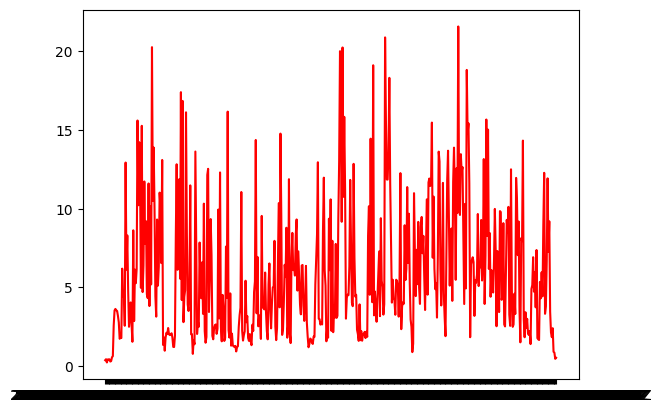

In [24]:
plt.plot(timestamp[1:], scores[1:], label='acc_x_max', color='r')
plt.show()


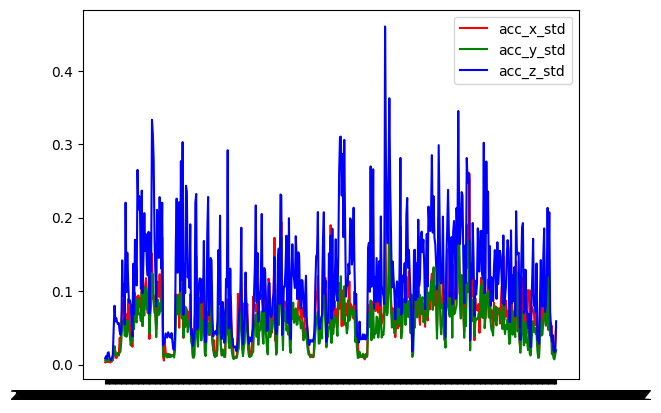

In [10]:
plt.plot(timestamp[1:], acc_x_std[1:], label='acc_x_std', color='r')
plt.plot(timestamp[1:], acc_y_std[1:], label='acc_y_std', color='g')
plt.plot(timestamp[1:], acc_z_std[1:], label='acc_z_std', color='b')
plt.legend(loc='upper right')
plt.show()


Post it to influx

In [25]:
def process_data(timestamp, latitude,longitude,roughness_score, speed, altitude):
    try:
        return {
            'timestamp': timestamp,
            'latitude': latitude,
            'longitude': longitude,
            'rougness_score': roughness_score,
            'speed': speed,
            'altitude': altitude
        }
    except Exception as e:
        print(f"Error: {e}")
        return None

print(timestamp[1], latitude[1],longitude[1], scores[1], speed[1], altitude[1])


2025-02-09T15:55:22.000Z 38.243356 21.725635 0.37148954266643097 0 -4.9


In [26]:
from influxdb_client import InfluxDBClient, Point
from influxdb_client.client.write_api import SYNCHRONOUS

# InfluxDB connection details
influxdb_url = "http://150.140.186.118:8086"
bucket = "AutoSenseAnalytics_imu_fft_score"
org = "students"
token = "kmVB5CFkQCqOSHpLPYc8N0C46IG_mAu9LnT1LdKGYC8k6_DlpUPAs31n9fP4sJaXjLJkyZ_Y9bvceMy5B3wobQ=="



In [27]:
points=[]
for i in range(1,len(timestamp)):
    point= Point("imu_fft_score")\
            .field("roughness", float(scores[i]))\
            .field("speed", float(speed[i]))\
            .field("altitude", float(altitude[i]))\
            .field("latitude", float(latitude[i]))\
            .field("longitude", float(longitude[i]))\
            .time(timestamp[i])
    points.append(point)

client = InfluxDBClient(url=influxdb_url, token=token, org=org)
try:
    write_api = client.write_api(write_options=SYNCHRONOUS)
    write_api.write(bucket=bucket, org=org, record=points)
    write_api.flush()
finally:
    client.close()
    print("InfluxDB updated successfully")


InfluxDB updated successfully
